#### 1. Procedimento Padrão

In [3]:
# Carregando as bibliotecas

import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.chdir('C:\\Users\\fabio\\OneDrive\\Anaconda Folder\\py\\02.Suporte')
from minhasfuncoes import *

#supress warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [4]:
#PADRÃO

#definição de período e ativo
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
start = '2015-1-1'
end = '2020-1-1'
ativo1 = 'IBOV'
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

#importaçao da base
df1 = extract_(ativo=ativo1,startfrom=datetime(2000,1,1),endto=datetime(2020,1,1))
df1.drop(['tick_volume','spread'], axis=1, inplace=True)
df1 = df1.set_index("time")

cl = pd.read_excel('cl.xlsx').set_index('time')
cl.drop(['ASAI3','AZUL4','BPAC11','BRDT3','CRFB3','GNDI3','HAPV3','IRBR3','PCAR3'],axis=1,inplace=True)

In [9]:
#criar função de operação

def func (df1):
    #variáveis básicas
    df1['retorno1'] = df1['close'].pct_change(1)
    df1['retorno2'] = df1['close'].pct_change(2)
    df1['retorno3'] = df1['close'].pct_change(3)
    df1['retorno10'] = df1['close'].pct_change(10)
    df1['retorno20'] = df1['close'].pct_change(20)

    df1['retorno1B'] = np.where(df1['retorno1']<0,0,1)
    df1['retorno2B'] = np.where(df1['retorno2']<0,0,1)
    df1['retorno3B'] = np.where(df1['retorno3']<0,0,1)

    df1['alvo1'] = df1['retorno1'].shift(-1)
    df1['alvo10'] = df1['retorno1'].shift(-10)

    df1['desv5'] = df1['close'].shift(1).rolling(5).std()
    df1['desv10'] = df1['close'].shift(1).rolling(10).std()

    ################ var1 => df1['oper'] = np.where(df1['z-score']<=-2,df1['alvo1'],0)
    #z-score
    zp = 40
    df1['mean-r'] = df1['retorno1'].rolling(zp).mean()
    df1['desv'] = df1['retorno1'].rolling(zp).std()
    df1['z-score'] = (df1['retorno1']-df1['mean-r'])/df1['desv']
    
    return(df1)

df1 = func(df1)

In [134]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df1, title="Pandas Profiling Report", explorative=True)

#### 2.Testes Iniciais

##### 2.1 Para um ativo

alvo1 médio = 0.05%
z-score < -2 : alvo1 médio = 0.44%
z-score intermed : alvo1 médio = 0.04%
z-score >  2 : alvo1 médio = -0.01%
---------------------------------


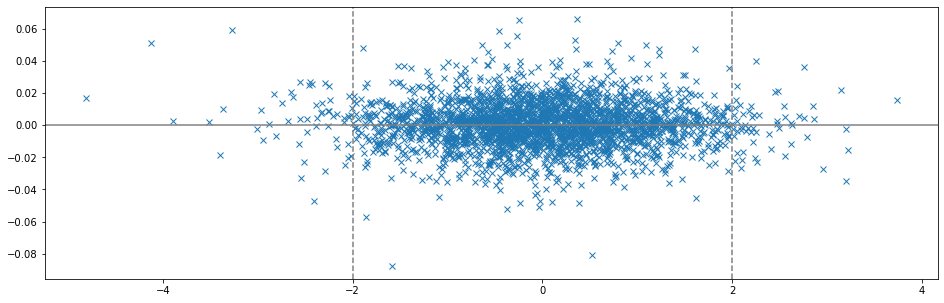

In [85]:
#variáveis testadas
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dsv = 'z-score'
alv = 'alvo1'
dist = 2
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

def grafico_dispercao (df=df1):
    plt.figure(figsize=(16,5))
    plt.plot(df[f'{dsv}'],df[f'{alv}'],'x')
    plt.axhline(0, color = 'grey', linestyle = '-')
    plt.axvline(-1 * dist, color = 'grey', linestyle = '--')
    plt.axvline(dist, color = 'grey', linestyle = '--')
grafico_dispercao(df=df1)
    
def analise_dispercao (df=df1):
    print(f'{alv} médio = ' + str ( round( df[f'{alv}'].mean()*100,2)        ) + '%')
    print(f'{dsv} < -2 : {alv} médio = ' + str ( round( df[df[f'{dsv}']<=-dist][f'{alv}'].mean()*100,2)        ) + '%')
    print(f'{dsv} intermed : {alv} médio = ' + str ( round( df[(df[f'{dsv}']>-dist)&(df[f'{dsv}']<dist)][f'{alv}'].mean()*100,2)        ) + '%')
    print(f'{dsv} >  2 : {alv} médio = ' + str ( round( df[df[f'{dsv}']>=dist][f'{alv}'].mean()*100,2)        ) + '%')
    print('---------------------------------')
analise_dispercao(df1)


In [86]:
from sklearn.model_selection import train_test_split

def analise_consistencia (df=df1):
    print('medindo consistência:')
    print('---------------------------------')

    pt1 , rest1 = train_test_split(df ,test_size=0.75,shuffle=False)
    pt2 , rest2 = train_test_split(rest1 ,test_size=0.667,shuffle=False)
    pt3 , pt4 = train_test_split(rest2 ,test_size=0.5,shuffle=False)

    analise_dispercao(pt1)
    analise_dispercao(pt2)
    analise_dispercao(pt3)
    analise_dispercao(pt4)
    
analise_consistencia(df1)

medindo consistência:
---------------------------------
alvo1 médio = 0.07%
z-score < -2 : alvo1 médio = 0.39%
z-score intermed : alvo1 médio = 0.06%
z-score >  2 : alvo1 médio = -0.85%
---------------------------------
alvo1 médio = 0.01%
z-score < -2 : alvo1 médio = 0.37%
z-score intermed : alvo1 médio = 0.0%
z-score >  2 : alvo1 médio = -0.04%
---------------------------------
alvo1 médio = 0.05%
z-score < -2 : alvo1 médio = 0.05%
z-score intermed : alvo1 médio = 0.04%
z-score >  2 : alvo1 médio = 0.46%
---------------------------------
alvo1 médio = 0.09%
z-score < -2 : alvo1 médio = 0.95%
z-score intermed : alvo1 médio = 0.06%
z-score >  2 : alvo1 médio = 0.34%
---------------------------------


##### 2.2 Para vários ativos

In [87]:
#gerando análise para ibov
def df_ibv(x=1):
    for i in np.arange(0,cl.shape[1]):

        #ativo
        atv = cl.columns[i]

        #preparar a base
        df1 = extract(ativo=atv,startfrom=datetime(2012,1,1),endto=datetime(2020,1,1)).set_index("time")
        df1 = df1.dropna()

        #função 1
        df1 = func(df1)
        a = df1[start:end]
        a['ordem'] = pd.Series(np.arange(0.00, a.shape[0])+0.01*i,index=a.index)

        if i == 0:
            df = a
        else:
            df = df.append(a)

    return(df)
df_ibv = df_ibv()
df_ibv = df_ibv.sort_values(by=['ordem'])

alvo1 médio = 0.12%
z-score < -2 : alvo1 médio = 0.23%
z-score intermed : alvo1 médio = 0.11%
z-score >  2 : alvo1 médio = 0.25%
---------------------------------


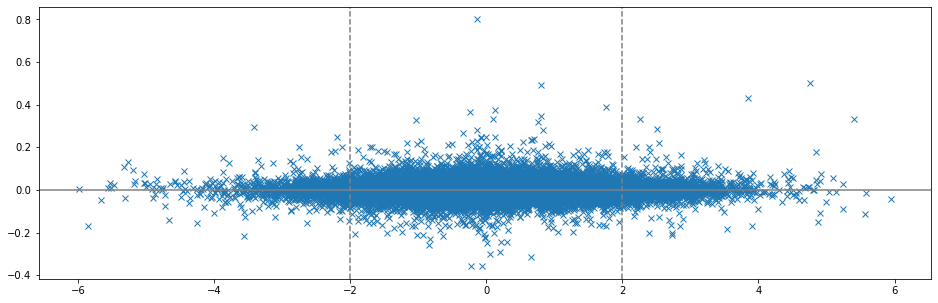

In [91]:
grafico_dispercao(df=df_ibv)
analise_dispercao(df=df_ibv)

In [92]:
analise_consistencia(df_ibv)

medindo consistência:
---------------------------------
alvo1 médio = 0.03%
z-score < -2 : alvo1 médio = 0.19%
z-score intermed : alvo1 médio = 0.02%
z-score >  2 : alvo1 médio = 0.24%
---------------------------------
alvo1 médio = 0.15%
z-score < -2 : alvo1 médio = 0.26%
z-score intermed : alvo1 médio = 0.15%
z-score >  2 : alvo1 médio = 0.03%
---------------------------------
alvo1 médio = 0.08%
z-score < -2 : alvo1 médio = 0.19%
z-score intermed : alvo1 médio = 0.07%
z-score >  2 : alvo1 médio = 0.07%
---------------------------------
alvo1 médio = 0.22%
z-score < -2 : alvo1 médio = 0.31%
z-score intermed : alvo1 médio = 0.21%
z-score >  2 : alvo1 médio = 0.6%
---------------------------------


#### 3.Setup Operacional

In [124]:
#variáveis da operação
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

#definição de período
start = '2017-1-1'
end = '2020-1-1'

#setup operacional
setup = 'z-score'    #nome da coluna com a variável teste
valid = 1            # 1 para >=    ou     0 para <=
sinal = 2            #trigger para a variável
alv = 'alvo1'        #nome da coluna alvo
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [125]:
def func_opera (atv1 = 'VALE3'):   #resultado operacional para um papel
    
    #ativo
    atv = atv1

    #preparar a base
    df1 = extract(atv,datetime(2010,1,1),datetime(2022,1,1)).set_index("time").dropna()
    df1.drop(['tick_volume','spread'], axis=1, inplace=True)

    #função 1
    df1 = func(df1)

    #corrigindo bug em KLBN11
    if atv1 == 'KLBN11':
        df1 = df1[2014-1-24:]
    
    #operacão
    df1 = df1[start:end]
    
    if valid == 1:
        df1['oper'] = np.where(df1[f'{setup}']>=sinal,df1[f'{alv}'],0)
    elif valid == 0:
        df1['oper'] = np.where(df1[f'{setup}']<=sinal,df1[f'{alv}'],0)
        
    df1['cumop'] = df1['oper'].cumsum()
    return(df1)

#func_opera('VALE3')

In [126]:
def func_opera_ibv(x=1):  #aplicar função para todos os papeis do ibov

    for i in np.arange(0,cl.shape[1]):
        
        try:
            df1 = func_opera(cl.columns[i])
            a = pd.DataFrame(df1['oper'])

            if i == 0:
                b = a
            else:
                b[cl.columns[i]] = a
        
        except:
            print(f'papel {cl.columns[i]} com erro')

    
    b = b.fillna(0)
    b['soma'] = b.apply(np.sum, axis=1)

    b['count'] = 0

    for i in np.arange(0,b.shape[0]):
        b.iloc[i,b.shape[1]-1] = sum(b.iloc[i,0:b.shape[1]-2]!=0)

    b['op'] = b['soma']/b['count']
    
    #retirar outliers
    b['op'] = np.where(b['op']>=0.4,0,b['op'])
    
    b['op'] = b['op'].fillna(0)
    b['cumop'] = b['op'].cumsum()

    result = b
    #result = b[['op','cumop']]

    return(result)
df_func_ibv = func_opera_ibv(1)

In [127]:
#referência
ref = extract_('IBOV',datetime(2010,1,1),datetime(2022,1,1)).set_index('time')
ref['op'] = ref['close'].pct_change(1)
ref = ref[start:end]
ref['cumop'] = ref['op'].cumsum()
#ref

#### 4. Backtest Results

##### 4.1 Timeline do trade

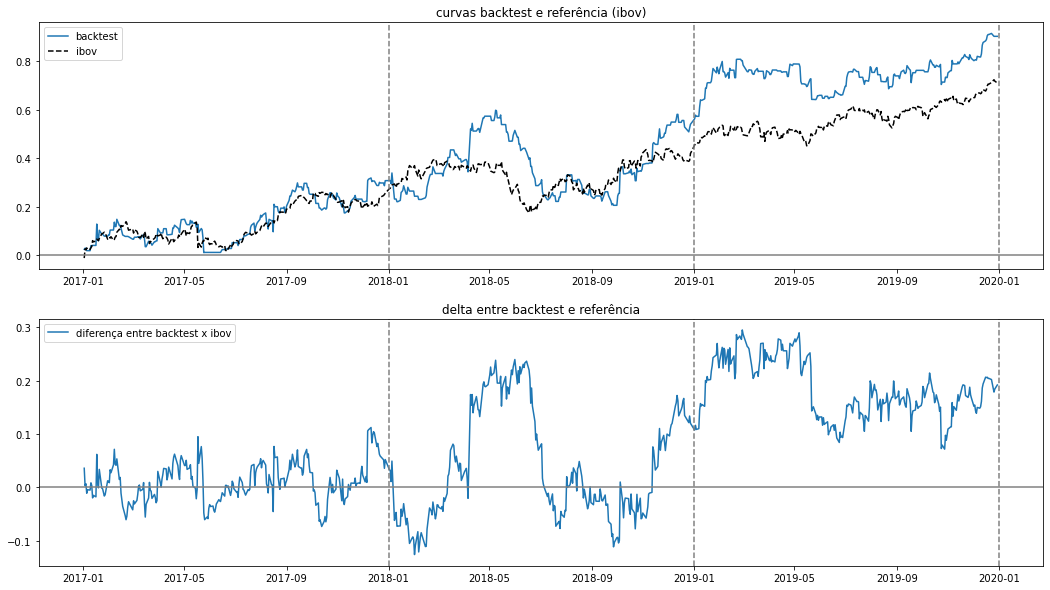

In [128]:
def plot() :
    plt.axhline(0, color = 'grey', linestyle = '-')
    if ('2021-01-01' <= end): plt.axvline('2020-01-01', color = 'grey', linestyle = '--')
    if ('2020-01-01' <= end): plt.axvline('2020-01-01', color = 'grey', linestyle = '--')
    if ('2019-01-01' >= start): plt.axvline('2019-01-01', color = 'grey', linestyle = '--')
    if ('2018-01-01' >= start): plt.axvline('2018-01-01', color = 'grey', linestyle = '--')
    if ('2017-01-01' >= start): plt.axvline('2017-01-01', color = 'grey', linestyle = '--')
    if ('2016-01-01' >= start): plt.axvline('2016-01-01', color = 'grey', linestyle = '--')
    if ('2015-01-01' >= start): plt.axvline('2015-01-01', color = 'grey', linestyle = '--') 
    if ('2014-01-01' >= start): plt.axvline('2014-01-01', color = 'grey', linestyle = '--')
    if ('2013-01-01' >= start): plt.axvline('2013-01-01', color = 'grey', linestyle = '--')
    if ('2012-01-01' >= start): plt.axvline('2012-01-01', color = 'grey', linestyle = '--')
    plt.legend()

#diferença entre backtest e ref
dif = df_func_ibv['cumop']-ref['cumop']
    
#plot
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(df_func_ibv['cumop'], label = 'backtest')
plt.plot(ref['cumop'], label = 'ibov', color = 'black', linestyle = '--')
plt.title('curvas backtest e referência (ibov)')
plot()

plt.subplot(2,1,2)
plt.plot(dif, label = 'diferença entre backtest x ibov')
plt.title('delta entre backtest e referência')
plot();



##### 4.2 Análise Descritiva

In [141]:
def anlsys (fig):
    print('max op  :  ' + str(round(max(fig['op'])*100,2))+'%')
    print('min op  :  ' + str(round(min(fig['op']),2)*100)+'%')
    print('average op  :  ' + str(round(fig[fig['op']!=0]['op'].mean()*100,2))+'%')
    print('median op  :  ' + str(round(fig[fig['op']!=0]['op'].median()*100,2))+'%')
    print('---------------------------------------------------')
    print('cum result of  :  '+str(round(fig['cumop'][fig.shape[0]-1]*100,1))+'%')
    print('std dev of op  :  ' + str(round(fig[fig['op']!=0]['op'].std()*100,2))+'%')
    print('sharpe ratio of  :  '+str(round(fig['cumop'][fig.shape[0]-1]/fig[fig['op']!=0]['op'].std(),1)))
    print('---------------------------------------------------')
    print('success rate op  :  ' + str(round((fig[fig['op']>0]['op'].count()/fig[fig['op']!=0]['op'].count())*100,2))+'%')
    print('days with op  :  ' + str(round((fig[fig['op']!=0]['op'].count()/fig['op'].count())*100,2))+'%')
    print('-----------------------------------------------------------------------------------------')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
    print('-----------------------------------------------------------------------------------------')


fig = df_func_ibv
print('df_func_ibv:')
anlsys (fig)

fig = ref
print('ref:')
anlsys (fig)

df_func_ibv:
max op  :  17.68%
min op  :  -11.0%
average op  :  0.19%
median op  :  0.2%
---------------------------------------------------
cum result of  :  90.3%
std dev of op  :  2.44%
sharpe ratio of  :  37.0
---------------------------------------------------
success rate op  :  54.64%
days with op  :  64.14%
-----------------------------------------------------------------------------------------
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
-----------------------------------------------------------------------------------------
ref:
max op  :  4.57%
min op  :  -9.0%
average op  :  0.1%
median op  :  0.12%
---------------------------------------------------
cum result of  :  71.0%
std dev of op  :  1.25%
sharpe ratio of  :  56.9
---------------------------------------------------
success rate op  :  54.4%
days with op  :  100.0%
-----------------------------------------------------------------------------------------
xxxxxxxxxxxxxxxxx

In [142]:
#ranking de resultados

rank_ = df_func_ibv

rank_ = rank_.drop(['oper','soma','count','op','cumop'],axis=1)

rank_ = pd.DataFrame(np.sum(rank_,axis=0)).sort_values(0)

print('bottom 10: ' + str(rank_.head(10)))
print("-----------------------")
print('\n top 10: ' + str(rank_.tail(10)))
print("-----------------------")
print('\n % of greater than zero return: ' + str(round(rank_[rank_[0]>0][0].count()/rank_[0].count()*100,1))+'%')

bottom 10:               0
ECOR3 -0.169298
YDUQ3 -0.153664
CIEL3 -0.141953
PETR4 -0.140596
BRML3 -0.105341
MULT3 -0.102803
ENEV3 -0.099796
VIVT3 -0.095209
GOAU4 -0.093092
BRAP4 -0.092741
-----------------------

 top 10:                0
MRFG3   0.169229
MGLU3   0.176578
SUZB3   0.201578
SULA11  0.206719
VVAR3   0.213287
CPLE6   0.215051
GOLL4   0.288512
BRFS3   0.303261
LCAM3   0.343000
USIM5   0.427670
-----------------------

 % of greater than zero return: 70.8%


##### 4.3 Drawdown

maximum DD : 39.2%


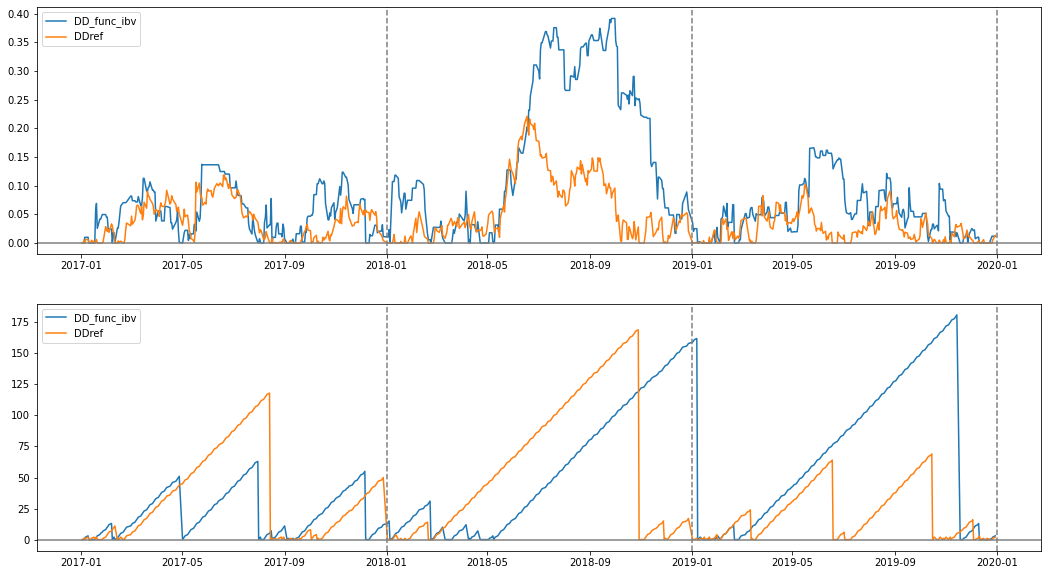

In [138]:
#drawdown
df11 = df_func_ibv

def DD(df11):
    
    df11 = df11[['op','cumop']]
    df11[['max','DD','DD_days']] = 0.00

    for i in np.arange(0,df11.shape[0]):
        df11['max'][i] = max(df11.iloc[0:i+1,1]) 
        df11['DD'][i] = df11['max'][i] - df11['cumop'][i]
        df11['DD_days'][i] = np.where(df11['DD'][i]==0,0,df11['DD_days'][i-1]+1)
    return(df11)

df11 = DD(df_func_ibv)
print('maximum DD : ' + str( round(max(df11['DD'])*100,1 )) + '%')

DD_func_ibv = DD(df_func_ibv)
DDref = DD(ref)

plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(DD_func_ibv['DD'], label = 'DD_func_ibv')
plt.plot(DDref['DD'], label = 'DDref')
plot()

plt.subplot(2,1,2)
plt.plot(DD_func_ibv['DD_days'], label = 'DD_func_ibv')
plt.plot(DDref['DD_days'], label = 'DDref')
plot();

##### 4.4 Volatilidade

''

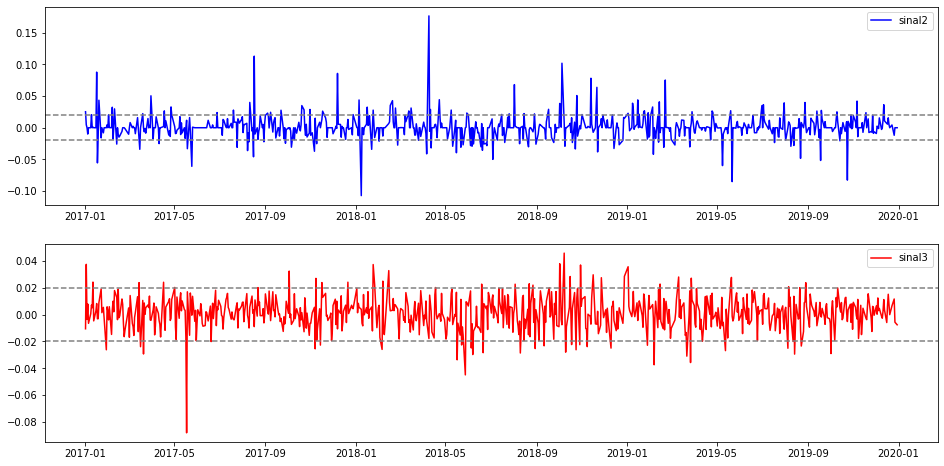

In [154]:
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(df_func_ibv['op'],color='blue', label='sinal2')
plt.axhline(-0.02, color='grey', linestyle='--')
plt.axhline(0.02, color='grey', linestyle='--')
plt.legend()

plt.subplot(2,1,2)
plt.plot(ref['op'],color='red', label='sinal3')
plt.axhline(-0.02, color='grey', linestyle='--')
plt.axhline(0.02, color='grey', linestyle='--')
plt.legend()
;

##### 4.5 Análisando diversos sinais de entrada

slice de períodos  x  resultado por quantidade de operações no dia


''

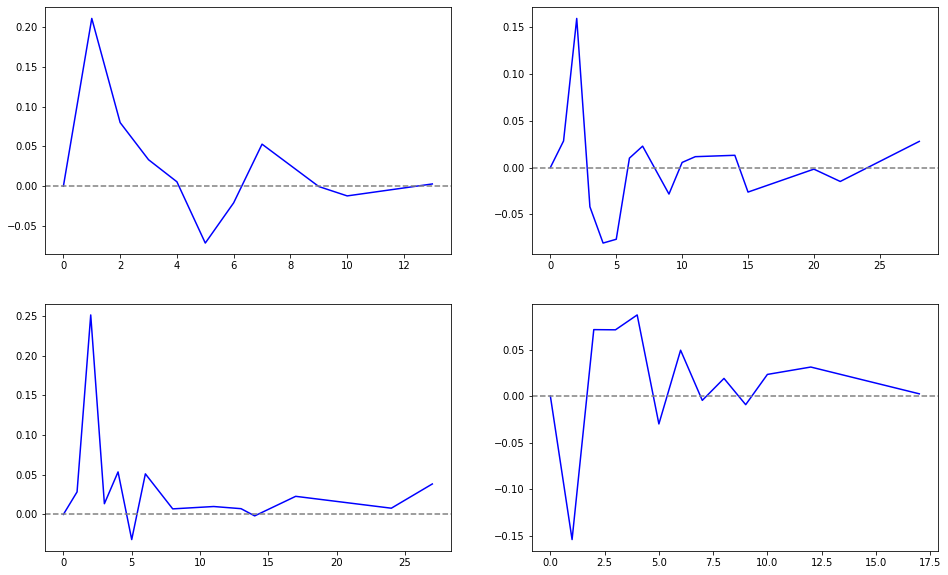

In [157]:
agf='mean'
testesign = df_func_ibv

from sklearn.model_selection import train_test_split

tteste = df_func_ibv

pt1 , tteste1 = train_test_split(tteste ,test_size=0.75,shuffle=False)
pt2 , tteste2 = train_test_split(tteste1 ,test_size=0.667,shuffle=False)
pt3 , pt4 = train_test_split(tteste2 ,test_size=0.5,shuffle=False)

agf = 'sum'
pss1 = pd.crosstab(pt1['count'],columns='media op',values = pt1['op'], aggfunc=f'{agf}')
pss2 = pd.crosstab(pt2['count'],columns='media op',values = pt2['op'], aggfunc=f'{agf}')
pss3 = pd.crosstab(pt3['count'],columns='media op',values = pt3['op'], aggfunc=f'{agf}')
pss4 = pd.crosstab(pt4['count'],columns='media op',values = pt4['op'], aggfunc=f'{agf}')


print('slice de períodos  x  resultado por quantidade de operações no dia')
plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.plot(pss1['media op'],color='blue', label= f'{testesign} parte1 {agf}')
plt.axhline(0,c='gray',linestyle='--')
#plt.legend()

plt.subplot(2,2,2)
plt.plot(pss2['media op'],color='blue', label= f'{testesign} parte1 {agf}')
plt.axhline(0,c='gray',linestyle='--')
#plt.legend()

plt.subplot(2,2,3)
plt.plot(pss3['media op'],color='blue', label= f'{testesign} parte1 {agf}')
plt.axhline(0,c='gray',linestyle='--')
#plt.legend()

plt.subplot(2,2,4)
plt.plot(pss4['media op'],color='blue', label= f'{testesign} parte1 {agf}')
plt.axhline(0,c='gray',linestyle='--')
#plt.legend()
;